<a href="https://colab.research.google.com/github/LeninGF/CoursesNotes/blob/main/MarkovRL/00-TragaMonedas-RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problema Tragamonedas

Se necesita:

- implementar el entorno
- implementar las políticas
- actualizar la función de valor (promedio)
- se usa ascenso del gradiente para actualizar la politica de GBA

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange # avance de las iteraciones
from typing import List # autocompletar en el notebook

## Clases para actualizar las políticas

Política promedio, política con una constante y la del gradiente

In [8]:
class ActualizarPolitica:
    def actualizar(self, politica, accion, recompensa):
        pass
    def reset(self):
        pass

class ActualizarMediaAritmetica(ActualizarPolitica):
    def __init__(self, num_acciones:int):
        self.n = num_acciones
        self.contador_accion = np.zeros(num_acciones) # incrementar el contador de la accion que se ha tomado
    def actualizar(self, politica:"Politica", accion:int, recompensa:float):
        self.contador_accion[accion]+=1 # el indice es la accion y asi se incrementa cada accion
        # cada accion tiene su propia q
        politica.q_est[accion]+=(recompensa-politica.q_est[accion])/self.contador_accion[accion]
    def reset(self):
        self.contador_accion = np.zeros(self.n)

class ActualizarConstante(ActualizarPolitica):
    def __init__(self, num_acciones:int, constante:float):
        self.n = num_acciones
        self.constante = constante
    def actualizar(self, politica:"Politica", accion:int, recompensa:float):
        politica.q_est[accion]+=self.constante*(recompensa-politica.q_est[accion]) # no se observa completo
    def reset(self):
        pass

class ActualizarGradiente(ActualizarPolitica):
    def __init__(self, num_acciones:int, con_baseline:bool, constante:float):
        self.n = num_acciones
        self.con_baseline = con_baseline
        self.constante = constante
        self.recompensa_media = 0
        self.tiempo = 0

    def actualizar(self, politica:"Politica", accion:int, recompensa:float):
        self.tiempo += 1
        self.recompensa_media+=(recompensa-self.recompensa_media)/self.tiempo
        one_hot = np.zeros(self.n)
        one_hot[accion] = 1
        if self.con_baseline:
            baseline = self.recompensa_media
        else:
            baseline = 0
        exp_h = np.exp(politica.q_est)
        prob_accion = exp_h/np.sum(exp_h) # softmax
        politica.q_est+=self.constante*(recompensa-baseline)*(one_hot-prob_accion) # no se observa completo
    def reset(self):
        self.recompensa_media = 0
        self.tiempo = 0

## Políticas

- GBA
- UCB

In [9]:
class Politica:
    def __init__(self, actualizar_politica:ActualizarPolitica, num_acciones:int, iniciales:float):
        self.actualizar_politica = actualizar_politica
        self.n = num_acciones
        self.iniciales = iniciales
        self.q_est = np.zeros(self.n)+self.iniciales
    def actuar(self):
        raise NotImplementedError("Actuar no Implementado")
    def avanzar(self, accion:int, recompensa:float):
        raise NotImplementedError("Avanzar no implementado")
    def reset(self):
        self.q_est = np.zeros(self.n)+self.iniciales
        self.actualizar_politica.reset()

class PoliticaEpsilonGreedy(Politica):
    def __init__(self, actualizar_politica:ActualizarPolitica, num_acciones:int, epsilon:float, iniciales:float=0.):
        super().__init__(actualizar_politica, num_acciones, iniciales)
        self.epsilon = epsilon
    def actuar(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.n)
        q_max = np.max(self.q_est)
        return np.random.choice(np.where(self.q_est==q_max)[0])
    def avanzar(self, accion: int, recompensa: float):
        self.actualizar_politica.actualizar(self, accion, recompensa)


class PoliticaUCB(Politica):
    # extremo superior de confianza
    def __init__(self, actualizar_politica:ActualizarPolitica, num_acciones:int, UCB_param:float, iniciales:float=0.):
        super().__init__(actualizar_politica, num_acciones, iniciales)
        self.UCB_param = UCB_param
        self.tiempo = 0
        self.contador_accion = np.zeros(self.n)
    def actuar(self):
        UCB_est = self.q_est+self.UCB_param*np.sqrt(np.log(self.tiempo+1)/(self.contador_accion+1e-5)) # numero agregado para evitar div por 0
        q_max = np.max(UCB_est)
        return  np.random.choice(np.where(UCB_est==q_max)[0])
    def avanzar(self, accion:int, recompensa:float):
        self.tiempo+=1
        self.contador_accion[accion]+=1
        self.actualizar_politica.actualizar(self, accion, recompensa)
    def reset(self):
        super().reset()
        self.contador_accion = np.zeros(self.n)
        self.tiempo = 0

class PoliticaGradiente(Politica):
    def __init__(self, actualizar_politica: ActualizarPolitica, num_acciones: int, iniciales: float=0):
        super().__init__(actualizar_politica, num_acciones, iniciales)
        self.q_est =np.zeros(self.n)
    def actuar(self):
        exp_h = np.exp(self.q_est)
        prob_accion = exp_h/np.sum(exp_h)
        return np.random.choice(np.arange(0, self.n), p=prob_accion)
    def avanzar(self, accion: int, recompensa: float):
        self.actualizar_politica.actualizar(self, accion, recompensa)

## Entorno

modelo de las maquinas traga monedas
cada maquina tiene una distribucion de probabilidad desconcida
las distribuciones de cada maquina empiezan en 0

In [10]:
class Entorno:
    def __init__(self, num_acciones, recompensa_verdadera=0.0):
        self.n = num_acciones
        self.recompensa_verdadera = recompensa_verdadera
        self.q_verdadera = np.random.randn(self.n)+self.recompensa_verdadera # distribucion normal desplazada
        self.mejor_accion = np.argmax(self.q_verdadera)
    def reset(self):
        self.q_verdadera = np.random.randn(self.n)+self.recompensa_verdadera
        self.mejor_accion = np.argmax(self.q_verdadera)
    def recompensa(self, accion:int):
        return np.random.randn()+self.q_verdadera[accion]

## Simulación

In [11]:
# iterar las politicas , tiempo cuantas iteraciones, intentos
k = 10 # num de bandidos

def simulador(intentos, tiempo, politicas:List[Politica], entorno:Entorno):
    recompensas = np.zeros((len(politicas), intentos, tiempo))
    contador_mejor_accion = np.zeros(recompensas.shape)
    for p, politica in enumerate(politicas):
        for i in trange(intentos):
            politica.reset()
            entorno.reset()
            for t in range(tiempo):
                accion = politica.actuar()
                recompesa = entorno.recompensa(accion)
                politica.avanzar(accion, recompesa)
                recompensas[p,i,t] = recompesa
                if accion == entorno.mejor_accion:
                    contador_mejor_accion[p,i,t] = 1
    media_contador_mejor_accion = contador_mejor_accion.mean(axis=1)
    media_recompensas = recompensas.mean(axis=1)
    return media_contador_mejor_accion, media_recompensas

## Plots

### Comparando Política Greedy para diferentes $\epsilon$

¿porque el numero de acciones se hace igual al numero de intentos y de bandidos?
Evaluar el balance entre explotación y exploración
a que se refiere con estancamiento


100%|██████████| 2000/2000 [00:50<00:00, 39.68it/s]


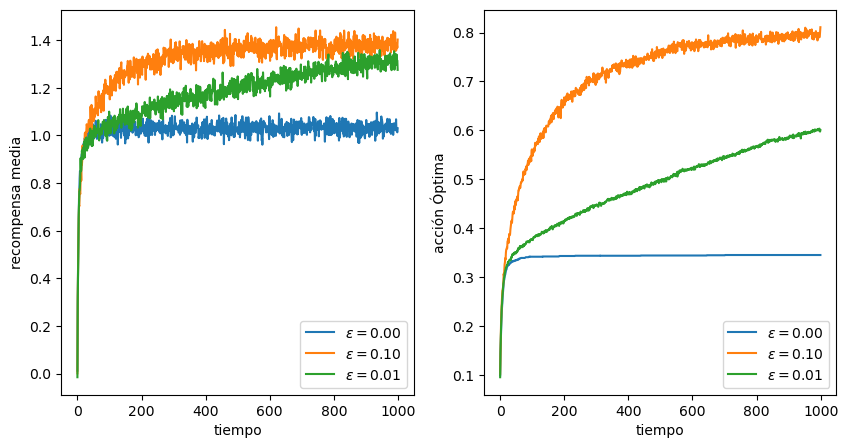

CPU times: user 2min 19s, sys: 5.96 s, total: 2min 25s
Wall time: 2min 23s


In [12]:
%%time
intentos = 2000; tiempo = 1000
epsilons = [0.,0.1,0.01] # controla el nivel de exploracion
# bandidos = [
#     PoliticaEpsilonGreedy(ActualizarMediaAritmetica(k), k, epsilons[0]),
#     PoliticaEpsilonGreedy(ActualizarMediaAritmetica(k), k, epsilons[1]),
#     PoliticaEpsilonGreedy(ActualizarMediaAritmetica(k), k, epsilons[2]),
# ]
bandidos = [PoliticaEpsilonGreedy(ActualizarMediaAritmetica(k),k,ep) for ep in epsilons]
entorno = Entorno(k)
contador_mejor_accion, recompensas = simulador(intentos, tiempo, bandidos, entorno)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
for eps, recompensas in zip(epsilons, recompensas):
    plt.plot(recompensas, label='$\epsilon=%.02f$' % (eps))
plt.xlabel('tiempo')
plt.ylabel('recompensa media')
plt.legend()

plt.subplot(1,2,2)
for eps, countador in zip(epsilons, contador_mejor_accion):      
    plt.plot(countador, label='$\epsilon=%.02f$' % (eps))
plt.xlabel('tiempo')
plt.ylabel('acción Óptima')
plt.legend()

plt.show()

### Comparación con y sin Optimismo

100%|██████████| 2000/2000 [00:46<00:00, 42.67it/s]


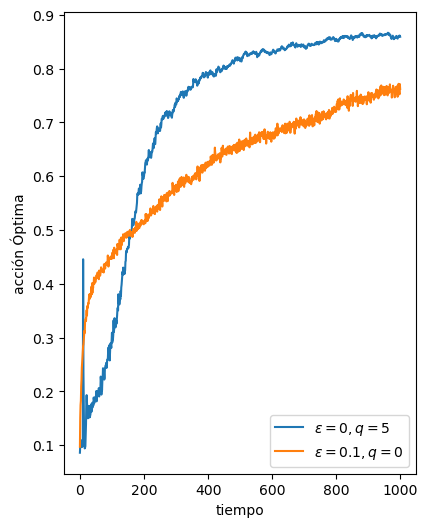

CPU times: user 1min 30s, sys: 4.46 s, total: 1min 34s
Wall time: 1min 33s


In [15]:
%%time
## Comparando con o sin optimismo
entorno = Entorno(k)

bandidos = [
    PoliticaEpsilonGreedy(ActualizarConstante(k, 0.1),k,0.0,iniciales=5), 
    PoliticaEpsilonGreedy(ActualizarConstante(k, 0.1),k,0.1,iniciales=0), 
]

contador_mejor_accion, _ = simulador(intentos, tiempo, bandidos, entorno)

plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
plt.plot(contador_mejor_accion[0], label='$\epsilon = 0, q = 5 $')
plt.plot(contador_mejor_accion[1], label='$\epsilon = 0.1, q = 0 $')
plt.xlabel('tiempo')
plt.ylabel('acción Óptima')
plt.legend()

plt.show()

### Comparación UCB (extremo superior) vs Epsilon Greedy

100%|██████████| 2000/2000 [00:46<00:00, 42.87it/s]


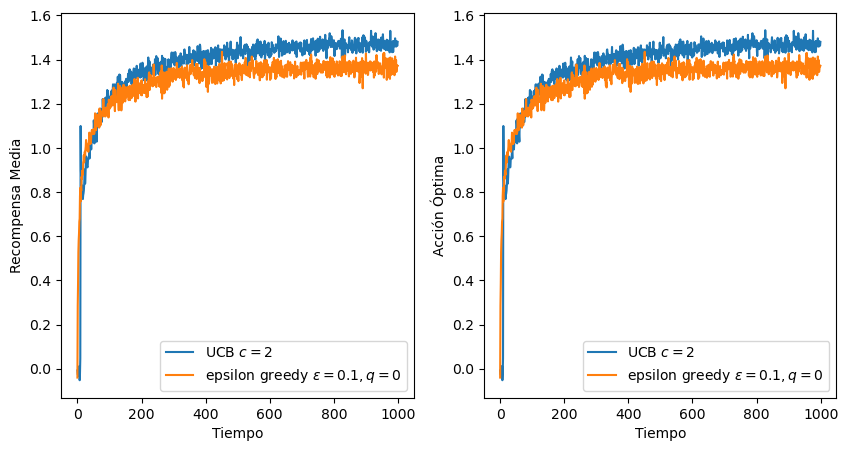

CPU times: user 1min 48s, sys: 5.82 s, total: 1min 54s
Wall time: 1min 53s


In [17]:
%%time
## comparacion UCB vs Epsilon Greedy

entorno = Entorno(k)

bandidos = [
    PoliticaUCB(ActualizarMediaAritmetica(k),k,2), 
    PoliticaEpsilonGreedy(ActualizarMediaAritmetica(k),k,0.1), 
]

contador_mejor_accion, recompensas = simulador(intentos, tiempo, bandidos, entorno)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(recompensas[0], label='UCB $c=2$')
plt.plot(recompensas[1], label='epsilon greedy $\epsilon = 0.1, q = 0 $')
plt.xlabel('Tiempo')
plt.ylabel('Recompensa Media')
plt.legend()


plt.subplot(1,2,2)
plt.plot(recompensas[0], label='UCB $c=2$')
plt.plot(recompensas[1], label='epsilon greedy $\epsilon = 0.1, q = 0 $')
plt.xlabel('Tiempo')
plt.ylabel('Acción Óptima')
plt.legend()

plt.show()

### Comparación gradiente con o sin baseline

100%|██████████| 2000/2000 [01:32<00:00, 21.69it/s]


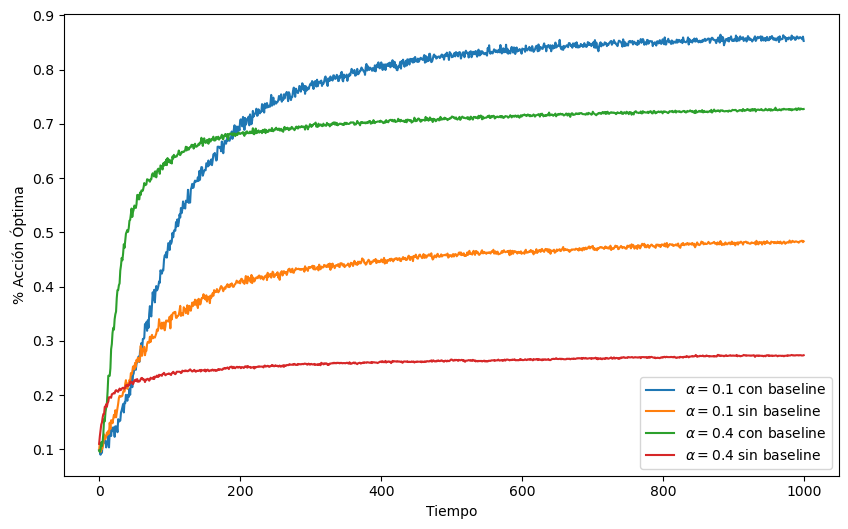

CPU times: user 5min 53s, sys: 15.6 s, total: 6min 8s
Wall time: 6min 4s


In [18]:
%%time

entorno = Entorno(k, recompensa_verdadera=4)

bandidos = []
bandidos.append(PoliticaGradiente(ActualizarGradiente(k,True, 0.1),k))
bandidos.append(PoliticaGradiente(ActualizarGradiente(k,False,0.1),k))
bandidos.append(PoliticaGradiente(ActualizarGradiente(k,True, 0.4),k))
bandidos.append(PoliticaGradiente(ActualizarGradiente(k,False,0.4),k))

contador_mejor_accion, _ = simulador(intentos, tiempo, bandidos, entorno)

labels = [r'$\alpha = 0.1$ con baseline',
          r'$\alpha = 0.1$ sin baseline',
          r'$\alpha = 0.4$ con baseline',
          r'$\alpha = 0.4$ sin baseline']

plt.figure(figsize=(10,6))

for i in range(len(bandidos)):
    plt.plot(contador_mejor_accion[i], label=labels[i])

plt.xlabel('Tiempo')
plt.ylabel('% Acción Óptima')
plt.legend()

plt.show()